<a href="https://colab.research.google.com/github/Maisho20/Machine-Learning/blob/main/Week%2010/Week_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nama: Sabbaha Naufal Erwanda**

**Kelas: TI-3A**

**NIM: 2141720221**

# Praktikum 1
RNN untuk Analisis Sentimen

## **Setup library**

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
# Construct a tf.data.Dataset
ds = tfds.load('imdb_reviews', split='train', shuffle_files=True)

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
 plt.plot(history.history[metric])
 plt.plot(history.history['val_'+metric], '')
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 plt.legend([metric, 'val_'+metric])

## **Setup input pipeline**

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# mengembalikan dataset
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
# Acak data untuk pelatihan dan membuat kumpulan pasangan
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Where to begin? <br /><br />#1 Amitabh\'s son, played by Akshaye Khanna, is 30.<br /><br />Amitabh\'s been in prison for 33+ years... he<br /><br />A) Telepathically transmitted the sperm home?<br /><br />B) Asked a nice Pakistani guard to mail it for him?<br /><br />C) They allow conjugal visits in secret Pakistani Jails<br /><br />D) All of the above<br /><br />E) The producers were having a little too much bhang at<br /><br />the time they approved the script?<br /><br />#2) Amrita Rao (Yummm!) wants Khanna - he\'s yum, yum, yummy... and apparently he wants her - who wouldn\'t, right?!... But, when her dad gets ratted out, and then killed (I hardly think this is a \'spoiler\' as you\'d have to be brain-dead and blind not to see this coming in the film) he\'s pretty emotionless towards this catastrophe and with the tip (metaphorically) of his hat, leaves her behind to save his dad, never mind her loss, and says (paraphrasing) "If god wills it, we\'ll meet again"... Basical

## **Buat Teks Encoder**

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[113,   6, 883, ...,   0,   0,   0],
       [  4, 162, 220, ...,   0,   0,   0],
       [  2, 114,  14, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Where to begin? <br /><br />#1 Amitabh\'s son, played by Akshaye Khanna, is 30.<br /><br />Amitabh\'s been in prison for 33+ years... he<br /><br />A) Telepathically transmitted the sperm home?<br /><br />B) Asked a nice Pakistani guard to mail it for him?<br /><br />C) They allow conjugal visits in secret Pakistani Jails<br /><br />D) All of the above<br /><br />E) The producers were having a little too much bhang at<br /><br />the time they approved the script?<br /><br />#2) Amrita Rao (Yummm!) wants Khanna - he\'s yum, yum, yummy... and apparently he wants her - who wouldn\'t, right?!... But, when her dad gets ratted out, and then killed (I hardly think this is a \'spoiler\' as you\'d have to be brain-dead and blind not to see this coming in the film) he\'s pretty emotionless towards this catastrophe and with the tip (metaphorically) of his hat, leaves her behind to save his dad, never mind her loss, and says (paraphrasing) "If god wills it, we\'ll meet again"... Basic

## **Buat Model**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

# evaluasi sebuah kalimat dua kali
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00912743]


In [ ]:
# predict on a sample text with padding

# evaluasi lagi dalam batch dengan kalimat yang lebih panjang
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 61ms/step
[0.00912743]


In [ ]:
# compile model Keras untuk mengonfigurasi proses pelatihan
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## **Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 52s 107ms/step - loss: 0.6505 - accuracy: 0.5545 - val_loss: 0.5064 - val_accuracy: 0.7536
Epoch 2/10
391/391 [==============================] - 25s 63ms/step - loss: 0.4235 - accuracy: 0.8041 - val_loss: 0.3867 - val_accuracy: 0.8245
Epoch 3/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3530 - accuracy: 0.8470 - val_loss: 0.3533 - val_accuracy: 0.8453
Epoch 4/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3287 - accuracy: 0.8575 - val_loss: 0.3360 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3168 - accuracy: 0.8656 - val_loss: 0.3371 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 29s 74ms/step - loss: 0.3083 - accuracy: 0.8709 - val_loss: 0.3343 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3041 - accuracy: 0.8717 - val_loss: 0.3230 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3147 - accuracy: 0.8616
Test Loss: 0.31472882628440857
Test Accuracy: 0.8615599870681763


(0.0, 0.6681822270154953)

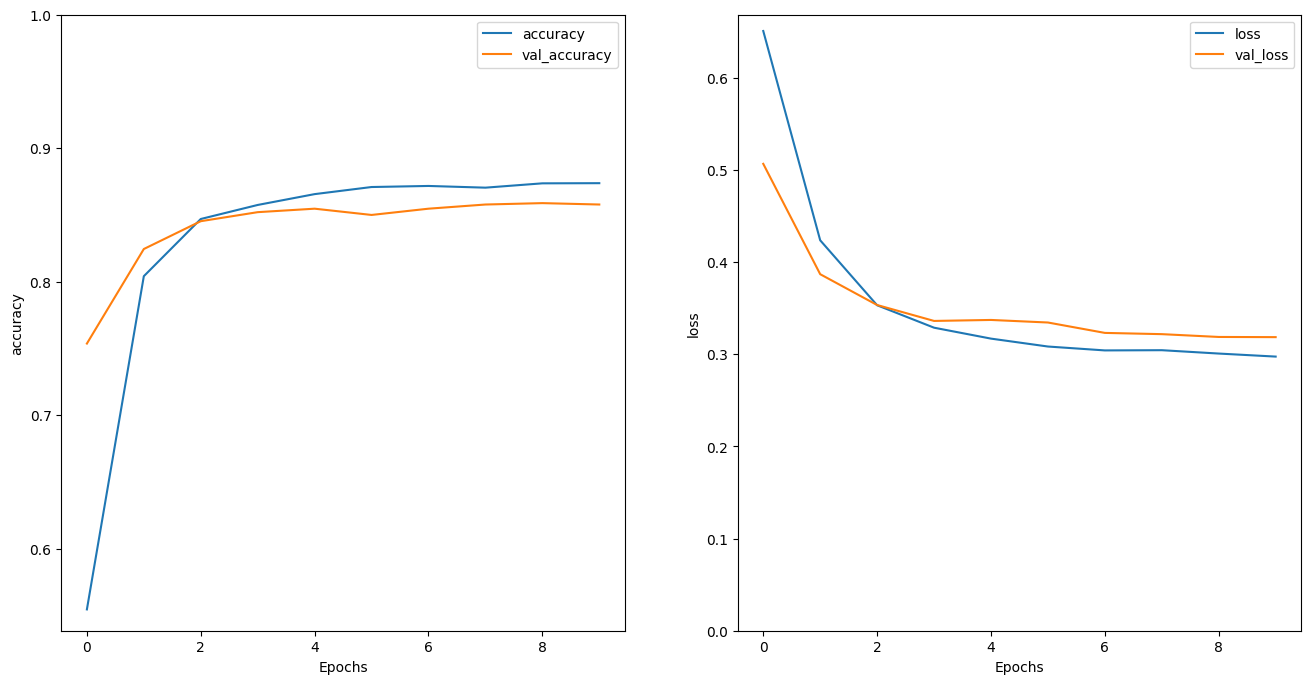

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


## **Stack two or more LSTM layers**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 76s 148ms/step - loss: 0.6157 - accuracy: 0.6006 - val_loss: 0.4220 - val_accuracy: 0.7932
Epoch 2/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3788 - accuracy: 0.8333 - val_loss: 0.3501 - val_accuracy: 0.8521
Epoch 3/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3378 - accuracy: 0.8556 - val_loss: 0.3318 - val_accuracy: 0.8526
Epoch 4/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3188 - accuracy: 0.8636 - val_loss: 0.3205 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3099 - accuracy: 0.8680 - val_loss: 0.3219 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 52s 132ms/step - loss: 0.3088 - accuracy: 0.8682 - val_loss: 0.3332 - val_accuracy: 0.8396
Epoch 7/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3043 - accuracy: 0.8693 - val_loss: 0.3211 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 47ms/step - loss: 0.3260 - accuracy: 0.8635
Test Loss: 0.32601091265678406
Test Accuracy: 0.8634799718856812


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[0.3646883]]


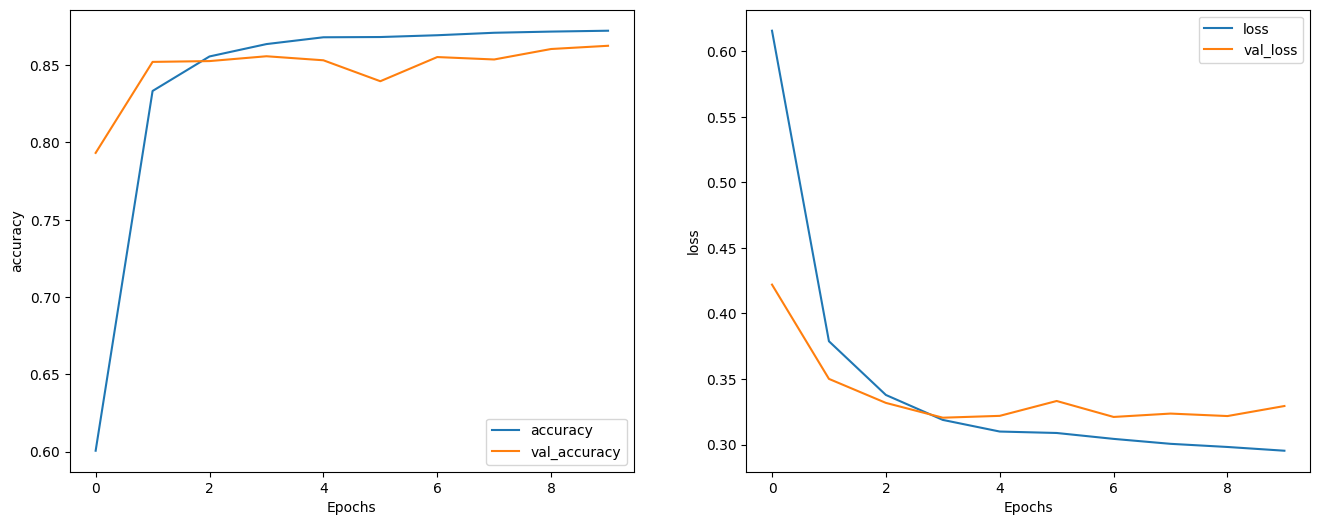

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2
Generator Teks dengan RNN

## **Setup**

**Import TensorFlow**

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

**Download Dataset Shakespeare**

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


**Load data**

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## **olah teks**

**Vectorize Teks**

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

**membuat `tf.keras.layers.StringLookup` layer**

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

**mengconvert token menjadi id**

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

**menggunakan metode `get_vocabulary()` dari `tf.keras.layers.StringLookup` sehingga token [UNK] disetel dengan cara yang sama.**

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

**mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter `tf.RaggedTensor`**

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

**menggunakan `tf.strings.reduce_join` untuk menggabungkan kembali karakter menjadi string.**

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

## **Prediksi**

**Membuat Trianing Set dan Target**

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

**mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan**

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


**menggabungkan token kembali menjadi string**

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


**Mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu**

In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


**Membuat Batch Training**

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## **Buat Model**

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## **Uji Model**

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


panjang urutan masukan adalah 100 tetapi model dapat dijalankan pada masukan dengan panjang berapa pun

In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


mengambil sampel dari distribusi keluaran, untuk mendapatkan indeks karakter aktual. Distribusi ini ditentukan oleh logit pada kosakata karakter.

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

## **Train Model**

**Tambahan optimizer dan fungsi loss**

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1886144, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

65.93137

Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile

In [ ]:
model.compile(optimizer='adam', loss=loss)

**Konfigurasi Checkpoints**

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

**Lakukan Proses Training**

In [ ]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 15s 65ms/step - loss: 2.7186
Epoch 2/20
172/172 [==============================] - 13s 61ms/step - loss: 1.9812
Epoch 3/20
172/172 [==============================] - 12s 61ms/step - loss: 1.7039
Epoch 4/20
172/172 [==============================] - 12s 62ms/step - loss: 1.5466
Epoch 5/20
172/172 [==============================] - 12s 61ms/step - loss: 1.4495
Epoch 6/20
172/172 [==============================] - 12s 58ms/step - loss: 1.3825
Epoch 7/20
172/172 [==============================] - 12s 60ms/step - loss: 1.3294
Epoch 8/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2843
Epoch 9/20
172/172 [==============================] - 12s 62ms/step - loss: 1.2436
Epoch 10/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2044
Epoch 11/20
172/172 [==============================] - 12s 59ms/step - loss: 1.1640
Epoch 12/20
172/172 [==============================] - 12s 61ms/step - loss: 1.1231
E

## **Generate Teks**

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

**menjalankan secara berulang untuk menghasilkan beberapa teks**

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Grace go wine by the other in thy dear,
Surrey him that Henry drag me whomatom our father's daughter
Anders forget the Duke of Clarence, nor it st,
All servant to my friendly.

YORK:
Angelo, the city lies!

Second Servant:
He is wife, sit, an 'twere thought upon: I hope, sir, ask your will,
Become the maid that came thy peace.
Think upon his fears and desperate me!
Near, this is he, three lords and knife;
For this wash daughter'd baseness of his chastisement,
That fair bad Nowling all Pitch'd 'badam.'

KING EDWARD:
Marry, and well I wot, then he doth so.

PETER:
Pretty Petracious sir: For he is well.
Do here no signifies accords and
That made thy widding-jock? do ye good he
How the king dost thou myself?

Third Servingman:
I say unto you,--
Being noble queen!

QUEEN ELIZABETH:
Hidesty his flies and thy friends
How touches escape impidence, as I haded!
Now wear it with her.

VOLUMNIA:
No, by: let's hence.

TRANIO:
She says ye.

HENRY BOLINGBROKE:
Go thrown, be since why from my s

**Menghasilkan teks lebih cepat**

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nProvoke it, his resolve: go you three-hearts of\ngeneral; and that seek the stubbarry hear me.\nSpeak allow you, sir? we must answer?\n\nDUKE VINCENTIO:\nNot to rather home arriving with the rest;\nAnd yet the day is our commitstoned; the wreck\nlike chastity; you may, the occupation aud\nA dozen so fasth; and with his realm,\nHath give my knems together, thanks with one that love\nAnd her as old and fire; and, in strokes,\nThough I am content to black it, thanks\nFor that person; here is he was forced to all.\n\nKATHARINA:\nI can a letter, you and I love use you:\n'Ton tears had show't a gentlewoman:\nHow silver sound; and that thou art potsiblize;\nThe words woo hadst certain to come.\n\nFather:\nLook, where we were, do it tell those mouth:\nAnd yet I know, and that my honest young shoot,\n'gainst the soft died, but we can cholar,\nWhen I should die with big and look upon my head;\nFor Edward, throw-doiety, you, more dark'd upon\nThis daunt, yes, then we should 

## **Ekspor Model Generator**

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Francid thou wives transported zenity,
Shall in threst thing able to expect
to her tender years til


# Tugas

Gunakan `tf.GradientTape` untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca `eager execution guide`.

Prosedurnya adalah:

1. Jalankan Model dan hitung loss dengan `tf.GradientTape`.
2. Hitung update dan terapkan pada model dengan optimizer

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 15s 63ms/step - loss: 2.7191


In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
  start = time.time()

  mean.reset_states()
  for (batch_n, (inp, target)) in enumerate(dataset):
    logs = model.train_step([inp, target])
    mean.update_state(logs['loss'])

    if batch_n % 50 == 0:
      template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
      print(template)

      # saving (checkpoint) the model every 5 epochs
      if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))
        print()
        print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
        print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
        print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.2136
Epoch 1 Batch 50 Loss 2.1178
Epoch 1 Batch 100 Loss 1.9555
Epoch 1 Batch 150 Loss 1.8325
Epoch 2 Batch 0 Loss 1.8070
Epoch 2 Batch 50 Loss 1.7581
Epoch 2 Batch 100 Loss 1.6887
Epoch 2 Batch 150 Loss 1.6515
Epoch 3 Batch 0 Loss 1.5838
Epoch 3 Batch 50 Loss 1.5967
Epoch 3 Batch 100 Loss 1.5445
Epoch 3 Batch 150 Loss 1.5065
Epoch 4 Batch 0 Loss 1.4208
Epoch 4 Batch 50 Loss 1.4693
Epoch 4 Batch 100 Loss 1.4270
Epoch 4 Batch 150 Loss 1.4251
Epoch 5 Batch 0 Loss 1.4208

Epoch 5 Loss: 1.4208
Time taken for 1 epoch 1.76 sec
________________________________________________________________________________
Epoch 5 Batch 50 Loss 1.4067

Epoch 5 Loss: 1.3847
Time taken for 1 epoch 4.69 sec
________________________________________________________________________________
Epoch 5 Batch 100 Loss 1.3456

Epoch 5 Loss: 1.3853
Time taken for 1 epoch 7.62 sec
________________________________________________________________________________
Epoch 5 Batch 150 Loss 1.3701

Epoch 5 L